In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import datetime
from skimage.io import imread
from skimage.transform import resize
from tensorflow.python.framework.ops import reset_default_graph
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
import os
import subprocess
import itertools
import data_utils

import os
import sys
sys.path.append(os.path.join('.', '..')) # Allow us to import shared custom 
                                         # libraries, like utils.py
import utils # contain various helper funcitons that aren't 
             # important to understand

def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[int(row), int(col)] = 1
    return out

# Tying everything together

Now that you have learned about the three most used network architectures: FNNs, CNNs and RNNs. It is time to combine these network types into a more advanced model. 

It often happens that you have a combination of data that cannot fully be modeled by one of these three types of network. Knowing how to divide the data into the right subsets, and then build a network that handles each subset efficiently can mean the difference between a great model and an unusable one. 

## Kaggle challenge

In this lab we will work on a data science challenge from [`kaggle.com`](kaggle.com).
Kaggle is a website to participate in real life challenges. Early 2017 it was bought by Google, who wanted access to the global community of data scientists it has created over the last 7 years. Since then Google have sponsored its expansion and now the prizes of the competitions and the amount of public datasets are bigger than ever. Most competitions on Kaggle have a dataset, an accuracy metric and a leaderboard to compare submissions.
You can read more about Kaggle [here](https://www.kaggle.com/about) and access a great amount of public datasets [here](https://www.kaggle.com/datasets).

**NB**: You will need a Kaggle account for this exercise!

The challenge we will pursue is the [_Leaf Classification_](https://www.kaggle.com/c/leaf-classification) challenge.
The dataset consists approximately 1,584 images of leaf specimens (16 samples each of 99 species) which have been converted to binary black leaves against white backgrounds. Three sets of features are also provided per image: a shape contiguous descriptor, an interior texture histogram, and a ﬁne-scale margin histogram. For each feature, a 64-attribute vector is given per leaf sample.

We will primarily look into the type of neural network best suited for handling this type of data. 
 * For images, usually the convolutional neural network does a pretty good job, 
 * For timeseries (like the shape) usually the RNN is the network of choice
 * For the describing features a FFN is often a great option

Lastly, we will train the model and put the outputs in a submission file that we can submit to kaggle.

## Visualizing the data

First we start out by looking at the images. We have already downloaded them for you, so all you have to do is to load the files into memory. For this, `glob` is a fantastic tool!

In [2]:
image_paths = glob.glob("images/*.jpg")
print("Amount of images =", len(image_paths))

Amount of images = 1584


Then we load in the training data, which is in CSV format. For this, we use [pandas](https://pandas.pydata.org/). Pandas is probably the most commonly used python library for Data Analysis, so if you have not worked with it before, you should probably check it out. 

In [3]:
# now loading the train.csv to find features for each training point
train = pd.read_csv('train.csv')
train_images = ['images/{}.jpg'.format(i) for i in train.id.values]
# notice how we "only" have 990 (989+0 elem) images for training, the rest is for testing
train.tail()

,id,species,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
985,1575,Magnolia_Salicifolia,0.060547,0.119140,0.007812,0.003906,0.000000,0.148440,0.017578,0.0,...,0.242190,0.000000,0.034180,0.000000,0.010742,0.000000,0.000000,0.000000,0.000000,0.018555
986,1578,Acer_Pictum,0.001953,0.003906,0.021484,0.107420,0.001953,0.000000,0.000000,0.0,...,0.170900,0.000000,0.018555,0.000000,0.011719,0.000000,0.000000,0.000977,0.000000,0.021484
987,1581,Alnus_Maximowiczii,0.001953,0.003906,0.000000,0.021484,0.078125,0.003906,0.007812,0.0,...,0.004883,0.000977,0.004883,0.027344,0.016602,0.007812,0.000000,0.027344,0.000000,0.001953
988,1582,Quercus_Rubra,0.000000,0.000000,0.046875,0.056641,0.009766,0.000000,0.000000,0.0,...,0.083008,0.030273,0.000977,0.002930,0.014648,0.000000,0.041992,0.000000,0.001953,0.002930
989,1584,Quercus_Afares,0.023438,0.019531,0.031250,0.015625,0.005859,0.019531,0.035156,0.0,...,0.000000,0.000000,0.002930,0.000000,0.012695,0.000000,0.000000,0.023438,0.025391,0.022461


With our training data and images loaded into memory. It is time to take a look at the data. Trying to classify leaves does not sound like a particularly difficult or interesting problem. We have probably all had teachers forcing us to do it on field trips as children.

But try to take a look at the 99 different categories and come up with a system that discern all 99 types of leaves from each other. 

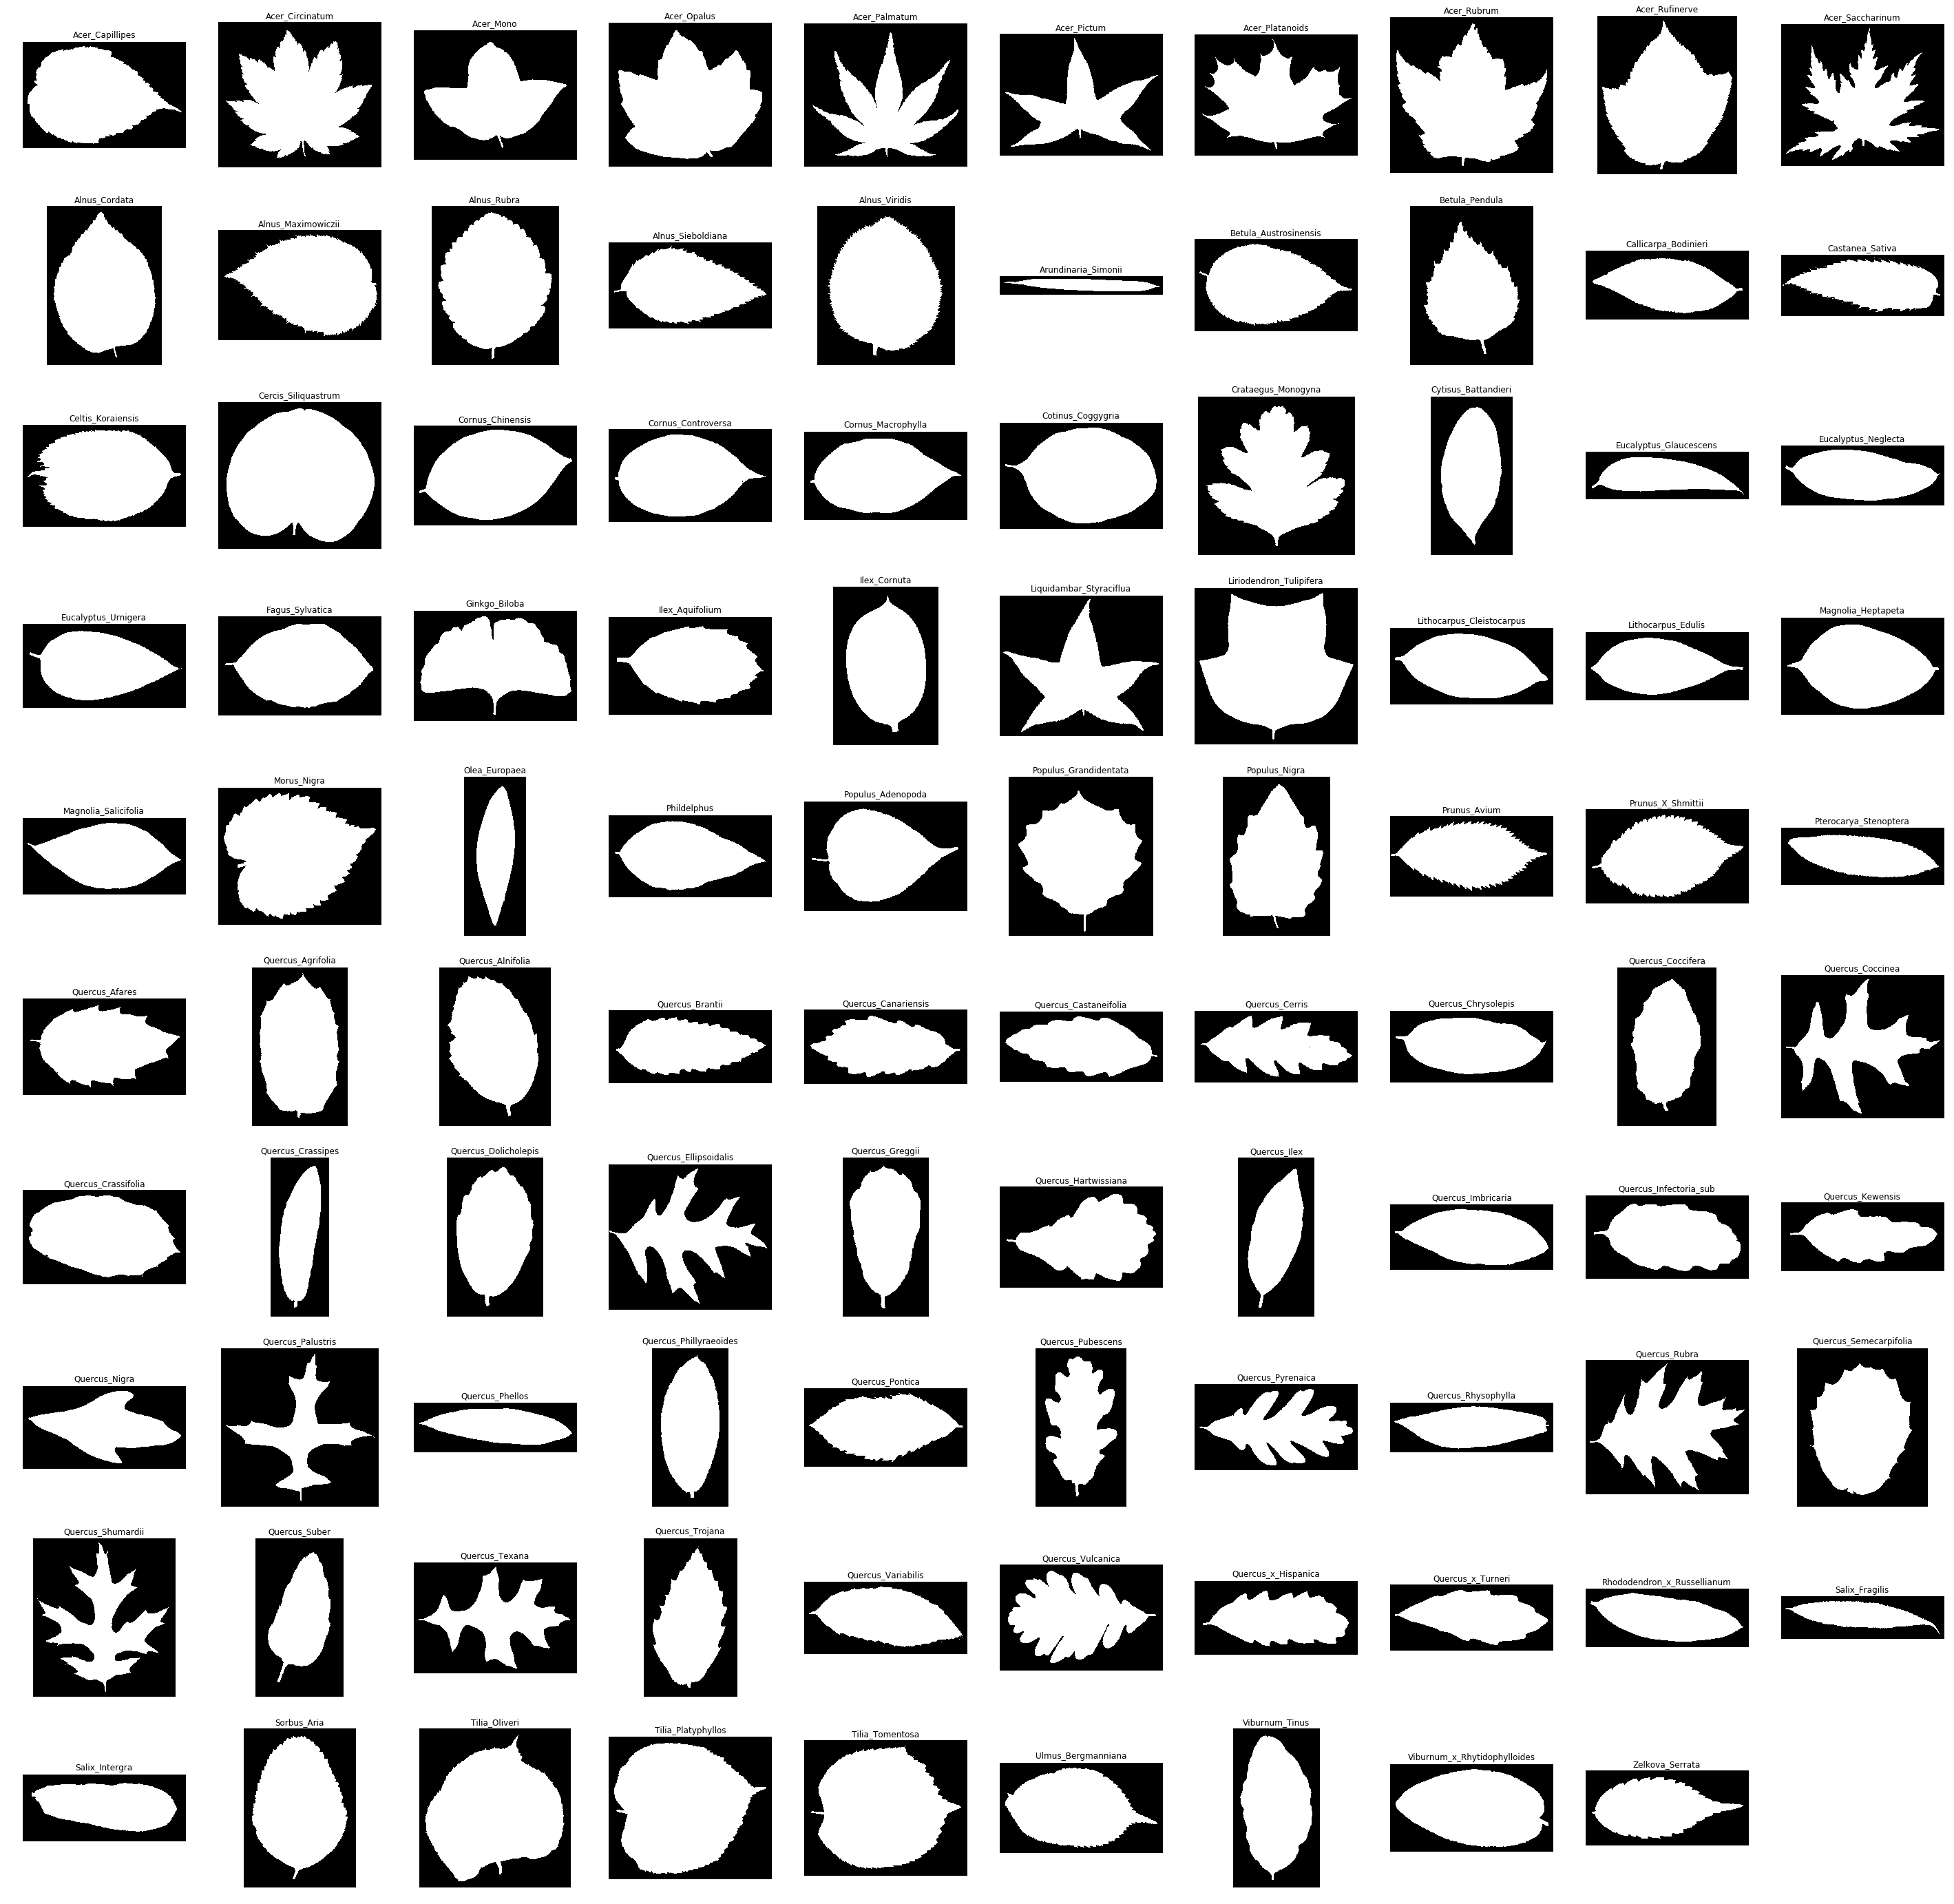

In [4]:
# First we find an example of each species in order to visualize it
species = np.array(sorted(train.species.unique()))
species_examples = [np.random.choice(train[train.species == s].id.values) for s in species]

# Then we gather its' index in our list of images in order to find the correct image
if os.name == 'nt':
    indexes = [image_paths.index('images\\{}.jpg'.format(i)) for i in species_examples] # Windows
else:
    indexes = [image_paths.index('images/{}.jpg'.format(i)) for i in species_examples] # Linux

# now plot 1 image from each category
fig = plt.figure(figsize=(50, 50))
for i, idx in enumerate(indexes):
    plt.subplot(10, 10, i + 1)
    image = imread(image_paths[idx], as_grey=True)
    plt.imshow(image, cmap='gray')
    plt.title("%s" % (species[i]))
    plt.axis('off')
plt.show()

As you can see, classifying leaves is actually a very tough problem. What makes it even worse, is that we cannot use all the image data we have available. In order to decrease the amount of computations needed, we need to reduce the size of the images as much as possible. On top of that our neural network only accepts fixed size input tensors. This means we will have to resize the images to ensure they all have the same sizes.

This resizing is problematic because it alters the shape of the leaves, and for some of them, this is their most distinctive feature. Take a look at `Salix_Intergra` in the bottom left corner. Describing this leaf without taking its' shape into account seems extremely difficult.

C:\Developer\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


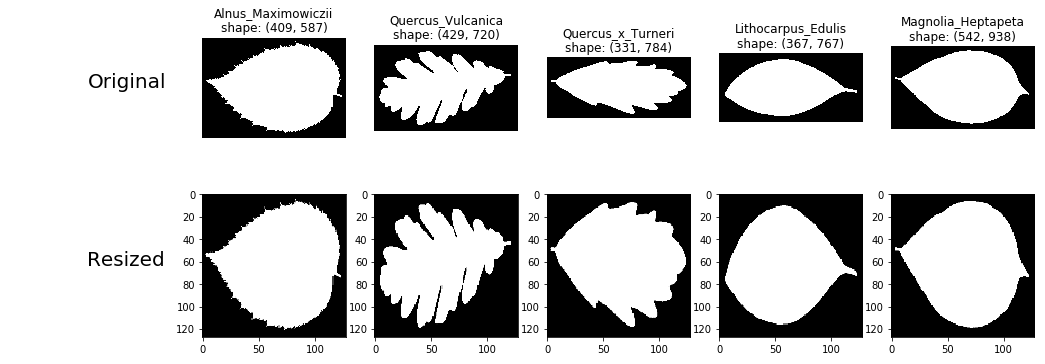

In [5]:
fig = plt.figure(figsize=(18, 6))
amount = 5
image_sample = np.random.choice(train_images, amount)

ax = plt.subplot(2, amount + 1, 1)
txt = ax.text(0.4, 0.5, 'Original', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
    
for i, path in enumerate(image_sample):
    plt.subplot(2, amount + 1, i + 2)
    image = imread(path, as_grey=True)
    plt.imshow(image, cmap='gray')
    _id = int(path.split('/')[-1].split('.')[0])
    plt.title("{0}\nshape: {1}".format(train[train.id == _id].species.values[0], image.shape))
    plt.axis('off')

ax = plt.subplot(2, amount + 1, len(image_sample) + 2)
txt = ax.text(0.4, 0.5, 'Resized', fontsize=20)
txt.set_clip_on(False)
plt.axis('off')
    
for i, path in enumerate(image_sample):
    i += len(image_sample) + 3
    plt.subplot(2, amount + 1, i)
    image = imread(path, as_grey=True)
    
    image = resize(image, output_shape=(128, 128)) # <-- This is the method that resizes the image
    
    plt.imshow(image, cmap='gray')
    
plt.show()

In [6]:
# now do similar as in train example above for test.csv
test = pd.read_csv('test.csv')
# notice that we do not have species here, we need to predict that ..!
test.tail()

,id,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
589,1576,0.000000,0.000000,0.003906,0.015625,0.041016,0.000000,0.017578,0.000000,0.005859,...,0.098633,0.000000,0.004883,0.000000,0.003906,0.0,0.0,0.018555,0.000000,0.000977
590,1577,0.000000,0.003906,0.003906,0.005859,0.017578,0.000000,0.017578,0.005859,0.000000,...,0.012695,0.004883,0.004883,0.002930,0.009766,0.0,0.0,0.090820,0.000000,0.016602
591,1579,0.017578,0.029297,0.015625,0.013672,0.003906,0.015625,0.025391,0.000000,0.000000,...,0.073242,0.000000,0.028320,0.000000,0.001953,0.0,0.0,0.000000,0.042969,0.006836
592,1580,0.013672,0.009766,0.060547,0.025391,0.035156,0.025391,0.039062,0.000000,0.003906,...,0.003906,0.000000,0.000977,0.000000,0.011719,0.0,0.0,0.000000,0.011719,0.018555
593,1583,0.000000,0.117190,0.000000,0.019531,0.000000,0.136720,0.001953,0.005859,0.000000,...,0.107420,0.012695,0.016602,0.000977,0.004883,0.0,0.0,0.015625,0.000000,0.017578


In [7]:
# and now do similar as in train example above for test.csv
sample_submission = pd.read_csv('sample_submission.csv')
# accordingly to these IDs we need to provide the probability of a given plant being present
sample_submission.tail()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
589,1576,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
590,1577,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
591,1579,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
592,1580,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101
593,1583,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,...,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101,0.010101


## Investigating the other features

Now that we have looked at the image data we have available, it is time to take a look at the other available features. Below we choose a random subset of the training data, and visualize the 3 types of available features:
* margin
* shape
* texture

Try to run it a few times to try and get an understanding of how the features differ from species to species.

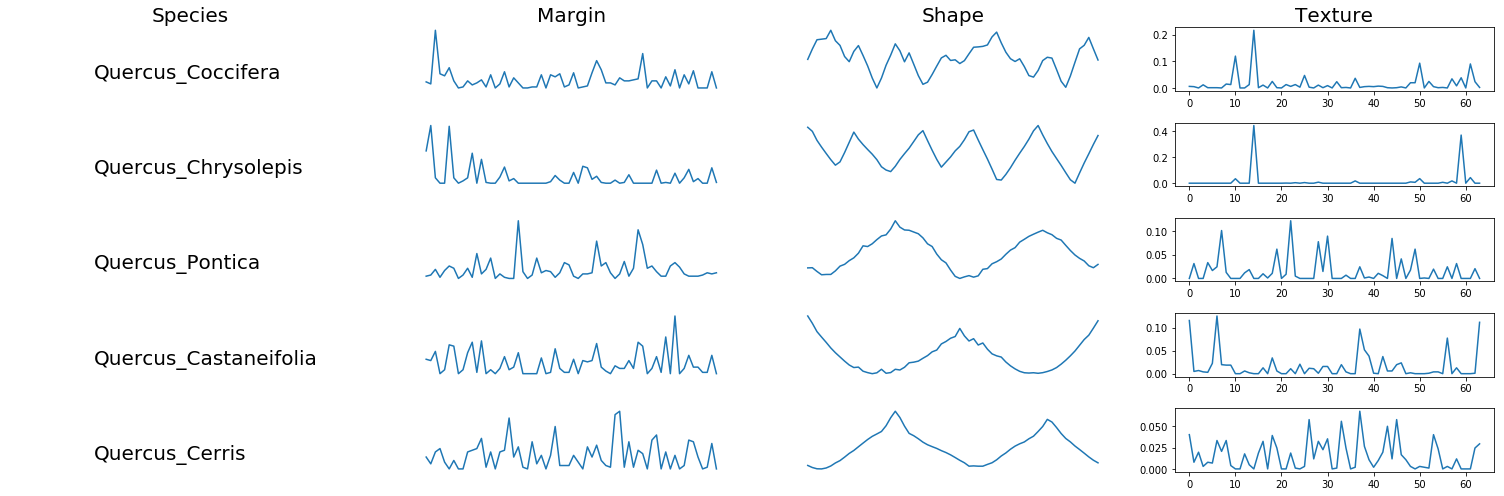

In [8]:
# try and extract and plot columns
X = train.as_matrix()
species = X[:, 1:2]
margin = X[:, 2:66]
shape = X[:, 66:130]
texture = X[:, 130:]

# let us plot some of the features
plt.figure(figsize=(21,7)) # Set the plot size
amount = 5 # Choose the amount of images we want to show at a time
for i, idx in enumerate(np.random.choice(range(len(train)), amount)):
    ax = plt.subplot(amount,4,1+i*4)
    txt = ax.text(0.2, 0.2, species[idx][0], fontsize=20)
    txt.set_clip_on(False)
    plt.axis('off')
    if i == 0:
        plt.title('Species', fontsize=20)
    plt.subplot(amount,4,2+i*4)
    plt.plot(margin[idx])
    if i == 0:
        plt.title('Margin', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,3+i*4)
    plt.plot(shape[idx])
    if i == 0:
        plt.title('Shape', fontsize=20)
    plt.axis('off')
    plt.subplot(amount,4,4+i*4)
    plt.plot(texture[idx])
    if i == 0:
        plt.title('Texture', fontsize=20)

plt.tight_layout()
plt.show()

# Exercise 1

1. Test various resizings of the image until you have found the smallest resizing of the image where you can still see differentiate between the images. Use IMAGE_SHAPE=(?, ?, 1) to reflect your choices.

So far we have learned about the feed forward neural network, the convolutional neural network and the recurrent neural network.
Given margin and texture are histograms, shape is a contigious value over a "time" dimension 

* (Optional) How could Margin, Shape and Texture be represented for classification?

* (Optional) Describe what network you would build and how you would represent the data points (image, margin, shape and texture).

# Defining the data loader

In [9]:
# loading data and setting up constants
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
#IMAGE_PATHS = glob.glob("images/*.jpg")
if os.name == 'nt':
    IMAGE_PATHS = glob.glob("images\\*.jpg")
else:
    IMAGE_PATHS = glob.glob("images/*.jpg")

NUM_CLASSES = 99
IMAGE_SHAPE = (128, 128, 1)
NUM_FEATURES = 64 # for all three features, margin, shape and texture
# train holds both X (input) and t (target/truth)
data = data_utils.load_data(train_path=TRAIN_PATH, 
                 test_path=TEST_PATH,
                 image_paths=IMAGE_PATHS,
                 image_shape=IMAGE_SHAPE[:2])
# to visualize the size of the dimensions of the data
# print
print("@@@Shape checking of data sets@@@")
# print
print("TRAIN")
print("\timages\t%s%f" % (data.train['images'].shape, data.train['images'].mean()))
print("\tmargins\t%s\t%f" % (data.train['margins'].shape, data.train['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.train['shapes'].shape, data.train['shapes'].mean()))
print("\ttextures%s\t%f" % (data.train['textures'].shape, data.train['textures'].mean()))
print("\tts\t %s" % (data.train['ts'].shape))
print("\twhile training, batch_generator will onehot encode ts to (batch_size, num_classes)")
# print()
print("TEST")
print("\timages\t%s\t%f" % (data.test['images'].shape, data.test['images'].mean())) 
print("\tmargins\t%s\t%f" % (data.test['margins'].shape, data.test['margins'].mean()))
print("\tshapes\t%s\t%f" % (data.test['shapes'].shape, data.test['shapes'].mean()))
print("\ttextures%s\t%f" % (data.test['textures'].shape, data.test['textures'].mean()))
print("\tids\t%s" % (data.test['ids'].shape))

C:\Developer\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


	0 of 990
	100 of 990
	200 of 990
	300 of 990
	400 of 990
	500 of 990
	600 of 990
	700 of 990
	800 of 990
	900 of 990
	0 of 594
	100 of 594
	200 of 594
	300 of 594
	400 of 594
	500 of 594
@@@Shape checking of data sets@@@
TRAIN
	images	(990, 128, 128, 1)0.462174
	margins	(990, 64)	0.015625
	shapes	(990, 64)	0.000607
	textures(990, 64)	0.015625
	ts	 990
	while training, batch_generator will onehot encode ts to (batch_size, num_classes)
TEST
	images	(594, 128, 128, 1)	0.463148
	margins	(594, 64)	0.015625
	shapes	(594, 64)	0.000604
	textures(594, 64)	0.015625
	ids	594


# Batch Generator

While training, we will not directly access the entire dataset, instead we have a `batch_generator` function to give us inputs aligned with their targets/ids in a size that our model can handle in memory (batch\_size).

Furthermore, the `batch_generator` also handles validation splitting.

In [10]:
dummy_batch_gen = data_utils.batch_generator(data, batch_size=64, num_classes=99, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))
# notice that mean is very different, which is why we use batch_norm in all input data in model

TRAIN
	images, (64, 128, 128, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

VALID
	images, (64, 128, 128, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ts, (64, 99)

TEST
	images, (64, 128, 128, 1)
	margins, (64, 64)
	shapes, (64, 64)
	textures, (64, 64)
	ids, 64


# Build the model

In [20]:
# Keras additions
from sklearn.preprocessing import StandardScaler

from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Convolution2D, MaxPooling2D, Flatten, Input, Concatenate, concatenate, BatchNormalization
from keras.optimizers import Nadam
from keras.models import load_model

from keras.preprocessing.image import ImageDataGenerator # Allows us to perform data augmentation.

Initially, we only work with the images

In [21]:
img_height = data.train['images'].shape[1]
img_width = data.train['images'].shape[2]
num_features = data.train['margins'].shape[1] # Also for textures

val_best = 0 # Used to determine when to save a model, set up here to ensure that best model is always kept

In [30]:
# We use the Functional API of Keras, which allows us to better customize the network for later
def combined_model():
    
    # Define inputs
    #texture = Input(shape=(num_features), name='texture')# To texture FFNN
    image = Input(shape=(img_height, img_width, 1), name='image') # To CNN

    
    margin = Input(shape=(num_features,), name='margin')# To margins FFNN


    # NOTE: GoogLeNet128 specifies Batch before activation
    
    # DEFINE FFNN for margins
    x_ffnn_marg = Dense(128, input_shape = (num_features,), kernel_initializer = 'glorot_normal')(margin)
    x_ffnn_marg = BatchNormalization()(x_ffnn_marg)
    x_ffnn_marg = Activation('relu')(x_ffnn_marg)
    x_ffnn_marg = Dropout(.5)(x_ffnn_marg)    
    
    x_ffnn_marg = Dense(128, input_shape = (num_features,), kernel_initializer = 'glorot_normal')(x_ffnn_marg)
    x_ffnn_marg = BatchNormalization()(x_ffnn_marg)    
    x_ffnn_marg = Activation('relu')(x_ffnn_marg)
    x_ffnn_marg = Dropout(.5)(x_ffnn_marg)        

    x_ffnn_marg = Dense(256, input_shape = (num_features,), kernel_initializer = 'glorot_normal')(x_ffnn_marg)
    x_ffnn_marg = BatchNormalization()(x_ffnn_marg)    
    x_ffnn_marg = Activation('relu')(x_ffnn_marg)
    x_ffnn_marg = Dropout(.5)(x_ffnn_marg) 
    
    
    # DEFINE FFNN for textures    
    
    #x_ffnn_text = 

    # Define the CNN section
    # Pass it through the first convolutional layer
    # this applies 16 convolution filters of size 5x5 each.    
    x_cnn = (Convolution2D(8, (5, 5), activation = 'relu', input_shape=(img_height, img_width, 1), kernel_initializer = 'glorot_normal'))(image)
    x_cnn = BatchNormalization()(x_cnn)        
    x_cnn = Activation('relu')(x_cnn)    
    x_cnn = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x_cnn)
    x_cnn = Dropout(.5)(x_cnn)  
    
    # Now through the second convolutional layer
    x_cnn = (Convolution2D(8, (5, 5), kernel_initializer = 'glorot_normal'))(x_cnn)
    x_cnn = BatchNormalization()(x_cnn)            
    x_cnn = Activation('relu')(x_cnn)        
    x_cnn = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x_cnn)
    x_cnn = Dropout(.5)(x_cnn)
    
    
    # Now through the third convolutional layer
    x_cnn = (Convolution2D(32, (5, 5), kernel_initializer = 'glorot_normal'))(x_cnn)
    x_cnn = BatchNormalization()(x_cnn)            
    x_cnn = Activation('relu')(x_cnn)        
    x_cnn = (MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))(x_cnn)
    x_cnn = Dropout(.5)(x_cnn)


    # Flatten our array
    x_cnn = Flatten()(x_cnn)

    # Add a fully connected layer just like in a normal MLP
    #x_cnn = BatchNormalization()(x_cnn)            
    x_cnn = Dense(124, activation='relu', kernel_initializer = 'glorot_normal')(x_cnn)
    x_cnn = Dropout(.5)(x_cnn)
    
    # COLLECT ALL
    concatenated = concatenate([x_ffnn_marg, x_cnn])
    ffnn_out = Dense(256, input_shape = (num_features,), activation = 'relu')(concatenated)   
    ffnn_out = BatchNormalization()(ffnn_out)                
    ffnn_out = Activation('relu')(ffnn_out)

    # Get the final output

    out = Dense(NUM_CLASSES, activation='softmax', kernel_initializer = 'glorot_normal')(ffnn_out)
    #out = Dense(NUM_CLASSES, activation='softmax', kernel_initializer = 'glorot_normal')(x_cnn)
    # How we create models with the Functional API
    model = Model(inputs=(image, margin), outputs=out)
    #model = Model(inputs=image, outputs=out)
    #nadam = Nadam(lr = 0.001, beta_1 = 0.995, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

    return model

print('Creating the model...')
model = combined_model()
print('Model created!')

Creating the model...
Model created!


# Train the model

In [31]:
datagen = ImageDataGenerator(
        data_format="channels_last",
        zoom_range = 0.2,  
        # Note, since we either have a 1 or a 0, we do not touch this part of the data.    
        fill_mode = 'constant', # Ensures correct filling
        #fill_mode = 'nearest', # Experimenting with this    
        cval = 0, # Fill value outside boundaries
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False, # set each sample mean to 0
        featurewise_std_normalization=False, # divide inputs by std of the dataset
        samplewise_std_normalization=False, # divide each input by its std
        zca_whitening=False, # apply ZCA whitening
        rotation_range=20, # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2, # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2, # randomly shift images vertically (fraction of total height)
        horizontal_flip=True, # randomly flip images
        vertical_flip=True) # randomly flip images

In [32]:
#Training Loop
BATCH_SIZE = 20
ITERATIONS = 2e4
LOG_FREQ = 10
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
SEED = 42
data_augmentation = True
VALID_EVERY = 100

batch_gen = data_utils.batch_generator(data, batch_size=BATCH_SIZE, num_classes=NUM_CLASSES,
                            num_iterations=ITERATIONS, seed=SEED, val_size=VALIDATION_SIZE)

train_loss = []
train_acc = []

print("\ttrain_loss \ttrain_acc \tvalid_loss \tvalid_acc")
try:
    for i, batch_train in enumerate(batch_gen.gen_train()):
        if i>=ITERATIONS:
            break
            
        if not data_augmentation:
            
            #hist = model.fit(batch_train['images'], batch_train['ts'], batch_size=BATCH_SIZE, epochs=1, verbose = 0)            
            hist = model.fit([batch_train['images'], batch_train['margins']], batch_train['ts'], batch_size=BATCH_SIZE, epochs=1, verbose = 0)
            train_loss.append(hist.history['loss'][0])
            train_acc.append(hist.history['acc'][0])
            
        else:
            #datagen.fit(batch_train['images'])

            #hist = model.fit_generator(datagen.flow(batch_train['images'], batch_train['ts'], batch_size=BATCH_SIZE), 
            #                           steps_per_epoch=1, epochs=1, verbose = 0)     
            
            for X_batch, Y_batch in datagen.flow(batch_train['images'], batch_train['ts'], batch_size=BATCH_SIZE, shuffle = False): # these are chunks of 32 samples
                hist = model.fit([X_batch, batch_train['margins']], batch_train['ts'], batch_size=BATCH_SIZE, epochs=1, verbose = 0)
                break
            
            # Total number of steps (batches of samples) to yield from generator before declaring one 
            # epoch finished and starting the next epoch. It should typically be equal to the number of 
            # unique samples of your dataset divided by the batch size.
            
            # Since we have already gotten a batch in the outer loop, this should just be 1, and not BATCH_SIZE
            
            train_loss.append(hist.history['loss'][0])
            train_acc.append(hist.history['acc'][0])            
        
        # validate
        if i % VALID_EVERY == 0:
            cur_acc = 0
            cur_loss = 0
            tot_num = 0
            # batch validation
            for batch_valid, num in batch_gen.gen_valid():
                # run validation
                #val_score, val_acc = model.evaluate(batch_valid['images'], batch_valid['ts'], batch_size=BATCH_SIZE, verbose = 0)
                val_score, val_acc = model.evaluate([batch_valid['images'], batch_valid['margins']], batch_valid['ts'], batch_size=BATCH_SIZE, verbose = 0)
        
                # costs
                cur_loss += val_score*num   # Validation loss
                cur_acc  += val_acc*num   # Validation accuracy 
                tot_num += num
                
            #print("Validation accuracy: {}".format(val_acc))                
            
            valid_loss = cur_loss / float(tot_num)
            valid_acc = (cur_acc / float(tot_num)) * 100
            train_loss = sum(train_loss) / float(len(train_loss))
            train_acc = sum(train_acc) / float(len(train_acc)) * 100
            print("%d:\t  %.2f\t\t  %.1f\t\t  %.2f\t\t  %.1f" % (i, train_loss, train_acc, valid_loss, valid_acc))
            train_loss = []
            train_acc = []
            
            if valid_acc > val_best:
                model.save('keras_model.h5')
                val_best = valid_acc
                print("Saving model")
            
except KeyboardInterrupt:
    pass

	train_loss 	train_acc 	valid_loss 	valid_acc
0:	  5.12		  0.0		  4.60		  1.0
100:	  4.87		  1.3		  4.60		  1.0
200:	  4.67		  1.5		  4.60		  1.0
300:	  4.49		  2.3		  4.60		  1.0
400:	  4.31		  3.2		  4.58		  2.0
500:	  3.95		  7.0		  4.50		  2.0
600:	  3.54		  10.6		  4.33		  11.1
700:	  3.10		  15.8		  3.40		  24.2
800:	  2.75		  22.9		  2.48		  45.5
900:	  2.54		  27.1		  1.94		  52.5
1000:	  2.35		  30.3		  1.84		  46.5
1100:	  2.24		  32.1		  1.63		  57.6
1200:	  2.06		  37.9		  1.53		  55.6
1300:	  1.99		  37.3		  1.45		  53.5
1400:	  1.97		  38.1		  1.40		  58.6
1500:	  1.87		  41.9		  1.37		  57.6
1600:	  1.82		  42.1		  1.29		  59.6
1700:	  1.75		  44.5		  1.42		  55.6
1800:	  1.73		  45.4		  1.25		  57.6
1900:	  1.69		  48.4		  1.33		  51.5
2000:	  1.65		  46.6		  1.11		  63.6
2100:	  1.55		  50.4		  1.22		  62.6
2200:	  1.53		  50.7		  1.23		  59.6
2300:	  1.56		  49.5		  1.11		  67.7
2400:	  1.56		  51.2		  1.22		  63.6
2500:	  1.46		  53.5		  1.18		  57.6
2600:	  1.45		  

# Submission to Kaggle

First we have to make testset predictions, then we have to place it in the submission file and the upload to kaggle for our score! You can upload at max 5 submissions a day.

In [ ]:
del model  # deletes the existing model
model = load_model('keras_model.h5') # Load the best model based on the validation set

In [24]:
# GET PREDICTIONS
# containers to collect ids and predictions
ids_test = []
preds_test = []
# run like with validation
for batch_test, num in batch_gen.gen_test():
    # get the result
    #y_out = model.predict(batch_test['images'], batch_size=BATCH_SIZE, verbose = 0)
    y_out = model.predict([batch_test['images'], batch_test['margins']], batch_size=BATCH_SIZE, verbose = 0)
    ids_test.append(batch_test['ids'])
    if num!=len(y_out):
        # in case of the last batch, num will be less than batch_size
        y_out = y_out[:num]
    preds_test.append(y_out)
# concatenate it all, to form one list/array
ids_test = list(itertools.chain.from_iterable(ids_test))
preds_test = np.concatenate(preds_test, axis=0)
assert len(ids_test) == len(preds_test)

# Make submission file

In [25]:
preds_df = pd.DataFrame(preds_test, columns=data.le.classes_)
ids_test_df = pd.DataFrame(ids_test, columns=["id"])
submission = pd.concat([ids_test_df, preds_df], axis=1)
submission.to_csv('submission_mlp.csv', index=False)
# below prints the submission, can be removed and replaced with code block below
submission.head()

,id,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
0,1026,8.547070e-01,5.400663e-13,3.051654e-04,2.171696e-07,3.827431e-09,3.278495e-08,9.704198e-09,1.832967e-10,1.400806e-09,...,1.291910e-11,2.879102e-07,1.360450e-10,2.440709e-05,1.570789e-04,7.353362e-07,3.911260e-13,5.680030e-08,1.420399e-08,3.485236e-04
1,4,1.230357e-07,2.562049e-08,1.927619e-09,4.879893e-06,6.816455e-13,8.898834e-09,1.494301e-06,1.918552e-09,3.284919e-09,...,1.659403e-09,4.525344e-07,1.882383e-07,1.181298e-07,1.107634e-06,2.469502e-08,3.786647e-10,2.327074e-09,1.298945e-09,1.560867e-09
2,1029,4.446374e-05,8.581559e-04,2.470661e-08,3.443167e-07,2.249675e-03,8.533335e-08,1.823076e-08,3.764070e-06,5.425409e-02,...,2.771518e-06,1.882020e-05,7.260841e-04,2.343565e-04,5.101976e-07,7.857911e-06,1.460235e-04,3.299442e-06,6.903259e-08,7.283067e-06
3,7,2.687182e-07,4.103088e-08,1.284229e-07,2.842671e-06,3.656458e-10,2.909357e-07,6.481009e-04,1.225466e-06,1.192396e-05,...,6.583219e-08,3.794864e-07,4.639701e-05,1.599858e-05,2.837108e-06,3.890154e-04,3.355447e-08,1.656800e-04,2.557056e-06,5.082586e-05
4,9,1.136991e-07,8.266649e-03,3.299519e-07,7.073505e-10,7.426943e-05,4.292715e-07,1.398936e-11,6.747260e-07,2.470854e-05,...,1.645506e-06,3.496692e-05,2.829682e-06,4.259626e-09,1.244643e-08,5.836148e-09,8.151201e-05,1.655530e-11,7.695687e-06,2.338262e-07


# Upload submission

1. Go to [`https://www.kaggle.com/c/leaf-classification/`](https://www.kaggle.com/c/leaf-classification/)
2. Make a submission
3. Click or drop your submission here (writing a description is good practice)
4. Submit

Success! 

# Exercise 2

1. Try to get the best score on Kaggle for this dataset as you can. (You can upload your solution multiple times as you progress)

A good implementation would get a score around 0.06399, try and see if you can get there, and explain what might have gone wrong if you cant. 

When doing trying to improve the network nothing is sacred, you can change learning rate, try testing various learning rates, batch sizes, validation sizes, etc. And most importantly, the validation set is very small (only 1 sample per class), etc.

To get you of to a good start we have created a list of thing you might want to try:
* Include l2 (fully connected and dropout layer)
* Try with L1 regularization (look at [tensorflow API](https://www.tensorflow.org/api_docs/python/tf/contrib/layers/l1_regularizer) for instructions)
* Include Dropout (Set DROPOUT to TRUE)
* Include L2 regularization
* Use only the image for training (with CNN) - comment on the increased time between iterations.
* Use dropout between the convolutional layers
* Include the RNN part
* Increase or decrease the batch size 
* Change the image size to be rectangular, bigger or smaller
* Try to combine the FFN, CNN, RNN parts in various ways

If your network is not performing as well as you would like it to, [here](http://theorangeduck.com/page/neural-network-not-working) is a great explanation of what might have gone wrong.